In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt


In [2]:
# Import turnstile data from the MTA website
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url, parse_dates=[['DATE','TIME']], keep_date_col=True))
    return pd.concat(dfs)   

# July-September 2019 and 2021
turnstiles_2019 = get_data([190706,190713,190720,190727,190803,190810,190817,190824,190831,190907,190914,190921,190928])
turnstiles_2021 = get_data([210703,210710,210717,210724,210731,210807,210814,210821,210828,210904,210911,210918,210925])

In [3]:
# strip whitespace in EXITS column
turnstiles_2019.columns = [column.strip() for column in turnstiles_2019.columns]
turnstiles_2021.columns = [column.strip() for column in turnstiles_2021.columns]

In [4]:
# Looks like the duplicates are caused by recovered AUD values (RECOVR AUD). 
# Since there's already a REGULAR entry for each, get rid of the duplicate entries.
turnstiles_2019.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_2019.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

# Drop the DESC Column.  To prevent errors in multiple run of cell, errors on drop is ignored
turnstiles_2019 = turnstiles_2019.drop(["DESC"], axis=1, errors="ignore")

# Same for 2021...
turnstiles_2021.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_2021.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)
# Drop the DESC Column.  To prevent errors in multiple run of cell, errors on drop is ignored
turnstiles_2021 = turnstiles_2021.drop(["DESC"], axis=1, errors="ignore")

In [5]:
block_2019 = (turnstiles_2019.groupby(["C/A", "UNIT", "SCP", "STATION","DATE_TIME","DATE"],as_index=False)
                    [["ENTRIES","EXITS"]].first())
block_2021 = (turnstiles_2021.groupby(["C/A", "UNIT", "SCP", "STATION","DATE_TIME","DATE"],as_index=False)
                    [["ENTRIES","EXITS"]].first())

In [6]:
block_2019[["PREV_DATE","PREV_ENTRIES", "PREV_EXITS"]] = (
    block_2019.groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE","ENTRIES", "EXITS"]]
    .apply(lambda grp: grp.shift(1)))
block_2021[["PREV_DATE","PREV_ENTRIES", "PREV_EXITS"]] = (
    block_2021.groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE","ENTRIES", "EXITS"]]
    .apply(lambda grp: grp.shift(1)))
block_2019.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
0,A002,R051,02-00-00,59 ST,2019-06-29 00:00:00,06/29/2019,7116734,2410183,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,2019-06-29 08:00:00,06/29/2019,7116770,2410218,06/29/2019,7116734.0,2410183.0
2,A002,R051,02-00-00,59 ST,2019-06-29 12:00:00,06/29/2019,7116856,2410288,06/29/2019,7116770.0,2410218.0
3,A002,R051,02-00-00,59 ST,2019-06-29 16:00:00,06/29/2019,7117076,2410346,06/29/2019,7116856.0,2410288.0
4,A002,R051,02-00-00,59 ST,2019-06-29 20:00:00,06/29/2019,7117340,2410387,06/29/2019,7117076.0,2410346.0


In [7]:
block_2019.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
block_2021.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [8]:
# determine daily entries and exits based on prev days
def get_daily_entries(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

def get_daily_exits(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

In [9]:
block_2019["DAILY_ENTRIES"] = (block_2019.apply(get_daily_entries, 
                                                            axis=1, max_counter=100000))
block_2019["DAILY_EXITS"] = (block_2019.apply(get_daily_exits, 
                                                          axis=1, max_counter=100000))
block_2021["DAILY_ENTRIES"] = (block_2021.apply(get_daily_entries, 
                                                            axis=1, max_counter=100000))
block_2021["DAILY_EXITS"] = (block_2021.apply(get_daily_exits, 
                                                          axis=1, max_counter=100000))
block_2019.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS
1,A002,R051,02-00-00,59 ST,2019-06-29 08:00:00,06/29/2019,7116770,2410218,06/29/2019,7116734.0,2410183.0,36.0,35.0
2,A002,R051,02-00-00,59 ST,2019-06-29 12:00:00,06/29/2019,7116856,2410288,06/29/2019,7116770.0,2410218.0,86.0,70.0
3,A002,R051,02-00-00,59 ST,2019-06-29 16:00:00,06/29/2019,7117076,2410346,06/29/2019,7116856.0,2410288.0,220.0,58.0
4,A002,R051,02-00-00,59 ST,2019-06-29 20:00:00,06/29/2019,7117340,2410387,06/29/2019,7117076.0,2410346.0,264.0,41.0
5,A002,R051,02-00-00,59 ST,2019-06-30 00:00:00,06/30/2019,7117480,2410406,06/29/2019,7117340.0,2410387.0,140.0,19.0


In [10]:
# Bronx Stations 2019

bronx_block_2019 = block_2019[((block_2019["STATION"] == 'V.CORTLANDT PK')
                                   |(block_2019["STATION"] == '238 ST')
                                   |(block_2019["STATION"] == '231 ST')
                                   |(block_2019["STATION"] == 'MARBLE HILL-225')
                                   |(block_2019["STATION"] == 'WOODLAWN')
                                   |(block_2019["STATION"] == 'MOSHOLU PKWY')
                                   |(block_2019["STATION"] == 'KINGSBRIDGE RD')
                                   |(block_2019["STATION"] == 'BEDFORD PK BLVD')
                                   |(block_2019["STATION"] == 'FORDHAM RD')
                                   |(block_2019["STATION"] == '183 ST')
                                   |(block_2019["STATION"] == 'BURNSIDE AV')
                                   |(block_2019["STATION"] == '176 ST')
                                   |(block_2019["STATION"] == 'MT EDEN AV')
                                   |(block_2019["STATION"] == '170 ST')
                                   |(block_2019["STATION"] == '167 ST')
                                   |(block_2019["STATION"] == '174-175 STS')
                                   |(block_2019["STATION"] == '182-183 STS')
                                   |(block_2019["STATION"] == 'TREMONT AV')
                                   |(block_2019["STATION"] == "NORWOOD 205 ST")
                                   |(block_2019["STATION"] == 'WAKEFIELD/241')
                                   |(block_2019["STATION"] == 'NEREID AV')
                                   |(block_2019["STATION"] == '233 ST')
                                   |(block_2019["STATION"] == '225 ST')
                                   |(block_2019["STATION"] == '219 ST')
                                   |(block_2019["STATION"] == 'BURKE AV')
                                   |(block_2019["STATION"] == 'ALLERTON AV')
                                   |(block_2019["STATION"] == 'BRONX PARK EAST')
                                   |(block_2019["STATION"] == 'EASTCHSTER/DYRE')
                                   |(block_2019["STATION"] == 'BAYCHESTER AV')
                                   |(block_2019["STATION"] == 'GUN HILL RD')
                                   |(block_2019["STATION"] == 'PELHAM PKWY')
                                   |(block_2019["STATION"] == 'MORRIS PARK')
                                   |(block_2019["STATION"] == 'BRONX PARK EAST')
                                   |(block_2019["STATION"] == 'E 180 ST')
                                   |(block_2019["STATION"] == 'WEST FARMS SQ')
                                   |(block_2019["STATION"] == '174 ST')
                                   |(block_2019["STATION"] == 'FREEMAN ST')
                                   |(block_2019["STATION"] == 'SIMPSON ST')
                                   |(block_2019["STATION"] == 'INTERVALE AV')
                                   |(block_2019["STATION"] == 'PROSPECT AV')
                                   |(block_2019["STATION"] == 'JACKSON AV')
                                   |(block_2019["STATION"] == '3 AV-149 ST')
                                   |(block_2019["STATION"] == 'PELHAM BAY PARK')
                                   |(block_2019["STATION"] == 'BUHRE AV')
                                   |(block_2019["STATION"] == 'MIDDLETOWN RD')
                                   |(block_2019["STATION"] == 'WESTCHESTER SQ')
                                   |(block_2019["STATION"] == 'ZEREGA AV')
                                   |(block_2019["STATION"] == 'CASTLE HILL AV')
                                   |(block_2019["STATION"] == 'PARKCHESTER')
                                   |(block_2019["STATION"] == 'ST LAWRENCE AV')
                                   |(block_2019["STATION"] == 'MORISN AV/SNDVW')
                                   |(block_2019["STATION"] == 'ELDER AV')
                                   |(block_2019["STATION"] == 'WHITLOCK AV')
                                   |(block_2019["STATION"] == 'HUNTS POINT AV')
                                   |(block_2019["STATION"] == 'LONGWOOD AV')
                                   |(block_2019["STATION"] == 'E 149 ST')
                                   |(block_2019["STATION"] == "E 143/ST MARY'S")
                                   |(block_2019["STATION"] == 'CYPRESS AV')
                                   |(block_2019["STATION"] == 'BROOK AV')
                                   |(block_2019["STATION"] == '3 AV 138 ST'))]

# Bronx Stations 2021

bronx_block_2021 = block_2021[((block_2021["STATION"] == 'V.CORTLANDT PK')
                                   |(block_2021["STATION"] == '238 ST')
                                   |(block_2021["STATION"] == '231 ST')
                                   |(block_2021["STATION"] == 'MARBLE HILL-225')
                                   |(block_2021["STATION"] == 'WOODLAWN')
                                   |(block_2021["STATION"] == 'MOSHOLU PKWY')
                                   |(block_2021["STATION"] == 'KINGSBRIDGE RD')
                                   |(block_2021["STATION"] == 'BEDFORD PK BLVD')
                                   |(block_2021["STATION"] == 'FORDHAM RD')
                                   |(block_2021["STATION"] == '183 ST')
                                   |(block_2021["STATION"] == 'BURNSIDE AV')
                                   |(block_2021["STATION"] == '176 ST')
                                   |(block_2021["STATION"] == 'MT EDEN AV')
                                   |(block_2021["STATION"] == '170 ST')
                                   |(block_2021["STATION"] == '167 ST')
                                   |(block_2021["STATION"] == '174-175 STS')
                                   |(block_2021["STATION"] == '182-183 STS')
                                   |(block_2021["STATION"] == 'TREMONT AV')
                                   |(block_2021["STATION"] == "NORWOOD 205 ST")
                                   |(block_2021["STATION"] == 'WAKEFIELD/241')
                                   |(block_2021["STATION"] == 'NEREID AV')
                                   |(block_2021["STATION"] == '233 ST')
                                   |(block_2021["STATION"] == '225 ST')
                                   |(block_2021["STATION"] == '219 ST')
                                   |(block_2021["STATION"] == 'BURKE AV')
                                   |(block_2021["STATION"] == 'ALLERTON AV')
                                   |(block_2021["STATION"] == 'BRONX PARK EAST')
                                   |(block_2021["STATION"] == 'EASTCHSTER/DYRE')
                                   |(block_2021["STATION"] == 'BAYCHESTER AV')
                                   |(block_2021["STATION"] == 'GUN HILL RD')
                                   |(block_2021["STATION"] == 'PELHAM PKWY')
                                   |(block_2021["STATION"] == 'MORRIS PARK')
                                   |(block_2021["STATION"] == 'BRONX PARK EAST')
                                   |(block_2021["STATION"] == 'E 180 ST')
                                   |(block_2021["STATION"] == 'WEST FARMS SQ')
                                   |(block_2021["STATION"] == '174 ST')
                                   |(block_2021["STATION"] == 'FREEMAN ST')
                                   |(block_2021["STATION"] == 'SIMPSON ST')
                                   |(block_2021["STATION"] == 'INTERVALE AV')
                                   |(block_2021["STATION"] == 'PROSPECT AV')
                                   |(block_2021["STATION"] == 'JACKSON AV')
                                   |(block_2021["STATION"] == '3 AV-149 ST')
                                   |(block_2021["STATION"] == 'PELHAM BAY PARK')
                                   |(block_2021["STATION"] == 'BUHRE AV')
                                   |(block_2021["STATION"] == 'MIDDLETOWN RD')
                                   |(block_2021["STATION"] == 'WESTCHESTER SQ')
                                   |(block_2021["STATION"] == 'ZEREGA AV')
                                   |(block_2021["STATION"] == 'CASTLE HILL AV')
                                   |(block_2021["STATION"] == 'PARKCHESTER')
                                   |(block_2021["STATION"] == 'ST LAWRENCE AV')
                                   |(block_2021["STATION"] == 'MORISN AV/SNDVW')
                                   |(block_2021["STATION"] == 'ELDER AV')
                                   |(block_2021["STATION"] == 'WHITLOCK AV')
                                   |(block_2021["STATION"] == 'HUNTS POINT AV')
                                   |(block_2021["STATION"] == 'LONGWOOD AV')
                                   |(block_2021["STATION"] == 'E 149 ST')
                                   |(block_2021["STATION"] == "E 143/ST MARY'S")
                                   |(block_2021["STATION"] == 'CYPRESS AV')
                                   |(block_2021["STATION"] == 'BROOK AV')
                                   |(block_2021["STATION"] == '3 AV 138 ST'))]
                      

In [11]:
daily_sum_entries_2019 = bronx_block_2019.groupby(["DATE"])[['DAILY_ENTRIES']].sum().reset_index()
daily_sum_entries_2019["DATE"]=pd.to_datetime(daily_sum_entries_2019["DATE"])

daily_sum_entries_2021 = bronx_block_2021.groupby(["DATE"])[['DAILY_ENTRIES']].sum().reset_index()
daily_sum_entries_2021["DATE"]=pd.to_datetime(daily_sum_entries_2021["DATE"])

print(daily_sum_entries_2019,daily_sum_entries_2021)

         DATE  DAILY_ENTRIES
0  2019-06-29       210462.0
1  2019-06-30       197906.0
2  2019-07-01       384486.0
3  2019-07-02       400041.0
4  2019-07-03       402510.0
..        ...            ...
86 2019-09-23       440101.0
87 2019-09-24       461407.0
88 2019-09-25       465982.0
89 2019-09-26       463460.0
90 2019-09-27       460723.0

[91 rows x 2 columns]          DATE  DAILY_ENTRIES
0  2021-06-26       112628.0
1  2021-06-27        96302.0
2  2021-06-28       174811.0
3  2021-06-29       209017.0
4  2021-06-30       178350.0
..        ...            ...
86 2021-09-20       224258.0
87 2021-09-21       231783.0
88 2021-09-22       233085.0
89 2021-09-23       230823.0
90 2021-09-24       232683.0

[91 rows x 2 columns]


In [12]:
July_avg_2019 = daily_sum_entries_2019[daily_sum_entries_2019["DATE"].dt.month==7]["DAILY_ENTRIES"].mean()
Aug_avg_2019 = daily_sum_entries_2019[daily_sum_entries_2019["DATE"].dt.month==8]["DAILY_ENTRIES"].mean()
Sept_avg_2019 = daily_sum_entries_2019[daily_sum_entries_2019["DATE"].dt.month==9]["DAILY_ENTRIES"].mean()

July_avg_2021 = daily_sum_entries_2021[daily_sum_entries_2021["DATE"].dt.month==7]["DAILY_ENTRIES"].mean()
Aug_avg_2021 = daily_sum_entries_2021[daily_sum_entries_2021["DATE"].dt.month==8]["DAILY_ENTRIES"].mean()
Sept_avg_2021 = daily_sum_entries_2021[daily_sum_entries_2021["DATE"].dt.month==9]["DAILY_ENTRIES"].mean()

print(July_avg_2019,Aug_avg_2019,Sept_avg_2019,July_avg_2021,Aug_avg_2021,Sept_avg_2021)

339475.70967741933 336087.6129032258 376585.037037037 157131.35483870967 157982.2258064516 182126.54166666666


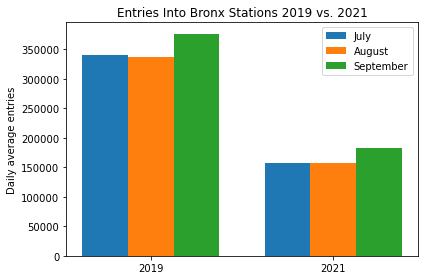

In [13]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['2019', '2021']
daily_entries_July = [July_avg_2019,July_avg_2021]
daily_entries_Aug = [Aug_avg_2019,Aug_avg_2021]
daily_entries_Sept = [Sept_avg_2019,Sept_avg_2021]


x = np.arange(len(labels))
width = 0.25     # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, daily_entries_July, width, label='July')
rects2 = ax.bar(x, daily_entries_Aug, width, label='August')
rects3 = ax.bar(x + width, daily_entries_Sept, width, label='September')

ax.set_ylabel('Daily average entries')
ax.set_title('Entries Into Bronx Stations 2019 vs. 2021')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.savefig("2019vs2021.jpg", dpi=199, facecolor='w', edgecolor='w',
        orientation='portrait', format=None,
        transparent=False, bbox_inches='tight', pad_inches=0.1)

plt.show();
